In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingRegressor, RandomForestRegressor
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
SEED = 0
np.random.seed(SEED)

# Figure 15.1 and 15.4

### Importing the data and splitting them !

In [ ]:
data = pd.read_csv('spam.txt', header=None, delimiter=' ')
sui = pd.read_csv('sui.txt', header=None)

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

sui = sui.values.flatten()
X_train = X[sui == 0]
y_train = y[sui == 0]
X_test = X[sui == 1]
y_test = y[sui == 1]

### Getting the 4 Curves ! (RandomForest, Boosting, Bagging, OOB) -> Using two ways Parallelized Code(for HPC) and Regular One 

In [ ]:
'''Not parallelized version'''
bagging_model = BaggingClassifier(random_state=SEED)
rf_model = RandomForestClassifier(random_state=SEED,oob_score=True)
gb_model = GradientBoostingClassifier(max_depth=5, random_state=SEED,learning_rate=1) # Learning rate is set to 1 to remove penalization

n_trees = range(1, 2501)

bagging_errors = []
rf_errors = []
gb_errors = []
oob_errors = []
for n in n_trees:
    bagging_model.set_params(n_estimators=n)
    rf_model.set_params(n_estimators=n)
    gb_model.set_params(n_estimators=n)

    bagging_model.fit(X_train, y_train)
    rf_model.fit(X_train, y_train)
    gb_model.fit(X_train, y_train)

    bagging_errors.append(1 - bagging_model.score(X_test, y_test))
    rf_errors.append(1 - rf_model.score(X_test, y_test))
    gb_errors.append(1 - gb_model.score(X_test, y_test))
    oob_errors.append(1 - rf_model.oob_score_) # OOB error


'''Parallelized version'''

bagging_model = BaggingClassifier(random_state=SEED)
rf_model = RandomForestClassifier(random_state=SEED,oob_score=True) # default value for m since it is not specified in the question
gb_model = GradientBoostingClassifier(max_depth=5, random_state=SEED,learning_rate=1) # Learning rate is set to 1 to remove penalization

n_trees = range(1, 2501)

def compute_errors(n):
    bagging_model.set_params(n_estimators=n)
    rf_model.set_params(n_estimators=n)
    gb_model.set_params(n_estimators=n)

    bagging_model.fit(X_train, y_train)
    rf_model.fit(X_train, y_train)
    gb_model.fit(X_train, y_train)

    bagging_error = 1 - bagging_model.score(X_test, y_test)
    rf_error = 1 - rf_model.score(X_test, y_test)
    gb_error = 1 - gb_model.score(X_test, y_test)
    oob_error = 1 - rf_model.oob_score_
    return bagging_error, rf_error, gb_error,oob_error

results = Parallel(n_jobs=-1, backend="multiprocessing")(delayed(compute_errors)(n) for n in n_trees)
bagging_errors, rf_errors, gb_errors,oob_errors = zip(*results)
np.save('bagging_errors.npy', bagging_errors)
np.save('rf_errors.npy', rf_errors)
np.save('gb_errors.npy', gb_errors)
np.save('oob_errors.npy',oob_errors)

### Getting the 10-Fold CV best error ! -> Two ways ( Parallelized Version and Not parallelized Version ) 

In [ ]:
'''Not Parallelized version'''
bagging_model = BaggingClassifier(random_state=0)
rf_model = RandomForestClassifier(random_state=0)  # default value for m since it is not specified in the question
gb_model = GradientBoostingClassifier(max_depth=5, random_state=SEED,learning_rate=1) # Learning rate is set to 1 to remove penalization

def cross_val_errors(model, X_train, y_train):
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    return 1 - cv_scores.mean()

best_bagging_trees = 0
best_rf_trees = 0
best_gb_trees = 0

best_bagging_error = float('inf')
best_rf_error = float('inf')
best_gb_error = float('inf')

for n in range(1, 2501):
    bagging_model.set_params(n_estimators=n)
    rf_model.set_params(n_estimators=n)
    gb_model.set_params(n_estimators=n)

    bagging_error = cross_val_errors(bagging_model, X_train, y_train)
    rf_error = cross_val_errors(rf_model, X_train, y_train)
    gb_error = cross_val_errors(gb_model, X_train, y_train)

    if bagging_error < best_bagging_error:
        best_bagging_error = bagging_error
        best_bagging_trees = n
    
    if rf_error < best_rf_error:
        best_rf_error = rf_error
        best_rf_trees = n

    if gb_error < best_gb_error:
        best_gb_error = gb_error
        best_gb_trees = n
        
'''Parallelized version'''

bagging_model = BaggingClassifier(random_state=SEED)
rf_model = RandomForestClassifier(random_state=SEED) # default value for m since it is not specified in the question
gb_model = GradientBoostingClassifier(max_depth=5, random_state=SEED,learning_rate=1,loss='log_loss') # Learning rate is set to 1 to remove penalization

def cross_val_errors(model, X_train, y_train):
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    return 1 - cv_scores.mean()

def evaluate_models(n):
    bagging_model.set_params(n_estimators=n)
    rf_model.set_params(n_estimators=n)
    gb_model.set_params(n_estimators=n)

    bagging_error = cross_val_errors(bagging_model, X_train, y_train)
    rf_error = cross_val_errors(rf_model, X_train, y_train)
    gb_error = cross_val_errors(gb_model, X_train, y_train)

    return n, bagging_error, rf_error, gb_error
# Since it was taking me so much time, I ran the code for bagging CV first then for random forest and finally for gradient boosting
results_X_CV = Parallel(n_jobs=-1)(delayed(evaluate_models)(n) for n in range(1, 2501))
results_X_CV = np.array(results_X_CV)
np.save('results_X_CV.npy', results_X_CV)

### Loading Data Saved from HPC

In [2]:
#10-fold CV errors
res_CV_bagging= np.load("results_bagging_CV.npy")
res_CV_rf= np.load("results_rf_CV.npy")
res_CV_gb= np.load("results_gb_CV.npy")

#Test errors
bagging_errors = np.load("bagging_errors.npy")
rf_errors = np.load("rf_errors.npy")
gb_errors = np.load("gb_errors.npy")
oob_errors = np.load("oob_errors.npy")

#Number of Trees
n_trees = range(1, 2501)

### Computing the best number of trees based on 10-fold cross validation !

In [3]:
# Finding the best n, res_CV_bagging, res_CV_rf, res_CV_gb are of the shape (2500, 2) -> (n, error), finding the best n is as simple as finding the index of the minimum error
val_chosen_by_cross_bagging = np.argmin(res_CV_bagging[:, 1]) 
val_chosen_by_cross_rf = np.argmin(res_CV_rf[:, 1]) 
val_chosen_by_cross_gb = np.argmin(res_CV_gb[:, 1]) 
print("Bagging best n: ", val_chosen_by_cross_bagging)
print("Random Forest best n: ", val_chosen_by_cross_rf)
print("Gradient Boosting best n: ", val_chosen_by_cross_gb)

Bagging best n:  41
Random Forest best n:  128
Gradient Boosting best n:  73


### PLotting 15.1 !

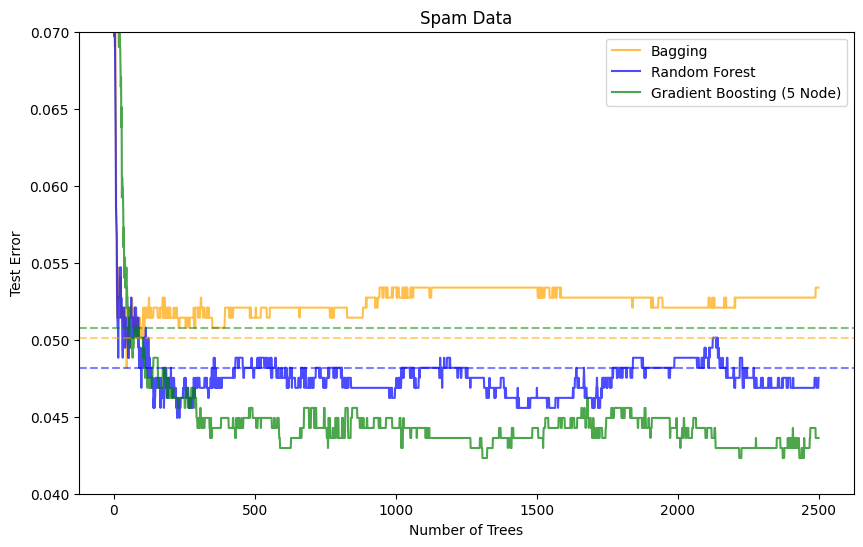

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(n_trees, bagging_errors, label='Bagging', color='orange',alpha=0.7)
plt.plot(n_trees, rf_errors, label='Random Forest', color='blue',alpha= 0.7)
plt.plot(n_trees, gb_errors, label='Gradient Boosting (5 Node)', color='green',alpha=0.7)

plt.axhline(y=bagging_errors[val_chosen_by_cross_bagging], color='orange', linestyle='--',alpha = 0.5)
plt.axhline(y=rf_errors[val_chosen_by_cross_rf], color='blue', linestyle='--',alpha = 0.5)
plt.axhline(y=gb_errors[val_chosen_by_cross_gb], color='green', linestyle='--',alpha = 0.5)

plt.ylim(0.04, 0.07)
plt.xlabel('Number of Trees')
plt.ylabel('Test Error')
plt.legend()
plt.title('Spam Data')
plt.show()

### PLotting 15.4!

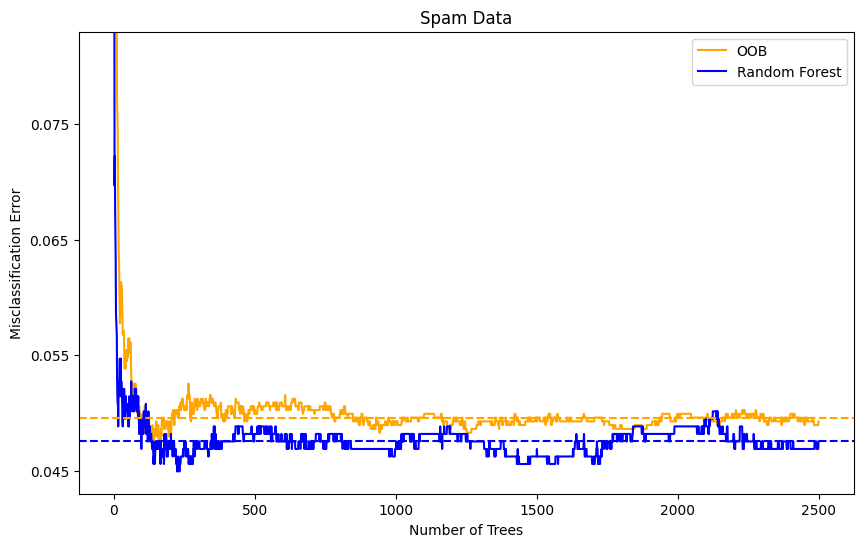

In [82]:
rf_errors = np.load("rf_errors.npy")

plt.figure(figsize=(10, 6))
plt.plot(n_trees, oob_errors, label='OOB', color='orange')
plt.plot(n_trees, rf_errors, label='Random Forest', color='blue')
plt.axhline(y=rf_errors[val_chosen_by_cross_rf], color='blue', linestyle='--')
plt.axhline(y=oob_errors[val_chosen_by_cross_rf], color='orange', linestyle='--')
plt.xlabel('Number of Trees')
plt.ylabel('Misclassification Error')
plt.yticks([0.045,0.055,0.065,0.075])
plt.legend()
plt.ylim(0.043, 0.083)
plt.title('Spam Data')
plt.show()

# Figure 15.3 !

### Importing the Data

In [ ]:
#Found the Data on Sklearn since the link was not working
california_housing = fetch_california_housing(as_frame=True)
california_housing.frame.to_csv('california_housing.csv', index=False)

### Splitting the Data

In [2]:
california_housing = pd.read_csv('california_housing.csv')
X = california_housing.iloc[:, :-1].values
y = california_housing.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [ ]:
'''Not Parallelized Code'''

# Note that we have used HistGradientBoostingRegressor for the first two models since it is faster than GradientBoostingRegressor( it is recommended for large datasets > 10,000 samples ) as per the sklearn documentation
SEC_1 = HistGradientBoostingRegressor(random_state=SEED,max_depth=4,learning_rate=0.05,loss='squared_error') # Learning rate is v (penalty term in 10.41), max depth is the interaction depth
SEC_2 = HistGradientBoostingRegressor(random_state=SEED,max_depth=6,learning_rate=0.05,loss='squared_error') # Learning rate is v (penalty term in 10.41), max depth is the interaction depth
SEC_3 = RandomForestRegressor(random_state=SEED,max_features=2) # max features is how many predictors to consider at each split, m = 2
SEC_4 = RandomForestRegressor(random_state=SEED,max_features=6) # max features is how many predictors to consider at each split, m =6

SEC_1_errors = []
SEC_2_errors = []
SEC_3_errors = []
SEC_4_errors = []
M_values = range(1, 1001)
for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    ALL_ERRORS = []
    for M in M_values:
        SEC_1.set_params(max_iter=M) # max_iter is the number of trees
        SEC_2.set_params(max_iter=M) # max_iter is the number of trees
        SEC_3.set_params(n_estimators=M) # n_estimators is the number of trees
        SEC_4.set_params(n_estimators=M) # n_estimators is the number of trees

        SEC_1.fit(X_train, y_train)
        SEC_2.fit(X_train, y_train)
        SEC_3.fit(X_train, y_train)
        SEC_4.fit(X_train, y_train)

        SEC_1_error = MAE(y_test, SEC_1.predict(X_test))
        SEC_2_error = MAE(y_test, SEC_2.predict(X_test))
        SEC_3_error = MAE(y_test, SEC_3.predict(X_test))
        SEC_4_error = MAE(y_test, SEC_4.predict(X_test))
        ALL_ERRORS.append(np.array([SEC_1_error, SEC_2_error, SEC_3_error, SEC_4_error]))
    ALL_ERRORS = np.array(ALL_ERRORS)
    SEC_1_errors.append(ALL_ERRORS[:, 0])
    SEC_2_errors.append(ALL_ERRORS[:, 1])
    SEC_3_errors.append(ALL_ERRORS[:, 2])
    SEC_4_errors.append(ALL_ERRORS[:, 3])

'''Parallelized Code'''

# Note that we have used HistGradientBoostingRegressor for the first two models since it is faster than GradientBoostingRegressor( it is recommended for large datasets > 10,000 samples ) as per the sklearn documentation
SEC_1 = HistGradientBoostingRegressor(random_state=SEED,max_depth=4,learning_rate=0.05) # Learning rate is v (penalty term in 10.41), max depth is the interaction depth
SEC_2 = HistGradientBoostingRegressor(random_state=SEED,max_depth=6,learning_rate=0.05) # Learning rate is v (penalty term in 10.41), max depth is the interaction depth
SEC_3 = RandomForestRegressor(random_state=SEED,max_features=2) # max features is how many predictors to consider at each split
SEC_4 = RandomForestRegressor(random_state=SEED,max_features=6) # max features is how many predictors to consider at each split

def evaluate_models(M):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    SEC_1.set_params(max_iter=M) # max_iter is the number of trees
    SEC_2.set_params(max_iter=M) # max_iter is the number of trees
    SEC_3.set_params(n_estimators=M) # n_estimators is the number of trees
    SEC_4.set_params(n_estimators=M) # n_estimators is the number of trees

    SEC_1.fit(X_train, y_train)
    SEC_2.fit(X_train, y_train)
    SEC_3.fit(X_train, y_train)
    SEC_4.fit(X_train, y_train)

    SEC_1_error = MAE(y_test, SEC_1.predict(X_test))
    SEC_2_error = MAE(y_test, SEC_2.predict(X_test))
    SEC_3_error = MAE(y_test, SEC_3.predict(X_test))
    SEC_4_error = MAE(y_test, SEC_4.predict(X_test))
    return SEC_1_error, SEC_2_error, SEC_3_error, SEC_4_error

def run_all(times=10):
    M_values = range(1, 1001)
    all_results = []

    for _ in range(times):
        results = Parallel(n_jobs=-1)(delayed(evaluate_models)(M) for M in M_values)
        all_results.append(np.array(results))

    all_results = np.array(all_results)
    averaged_results = np.mean(all_results, axis=0)

    SEC_1_errors, SEC_2_errors, SEC_3_errors, SEC_4_errors = zip(*averaged_results)
    np.save('SEC_1_errors.npy', SEC_1_errors)
    np.save('SEC_2_errors.npy', SEC_2_errors)
    np.save('SEC_3_errors.npy', SEC_3_errors)
    np.save('SEC_4_errors.npy', SEC_4_errors)

run_all(times=10)

### Plotting the Figure 15.3

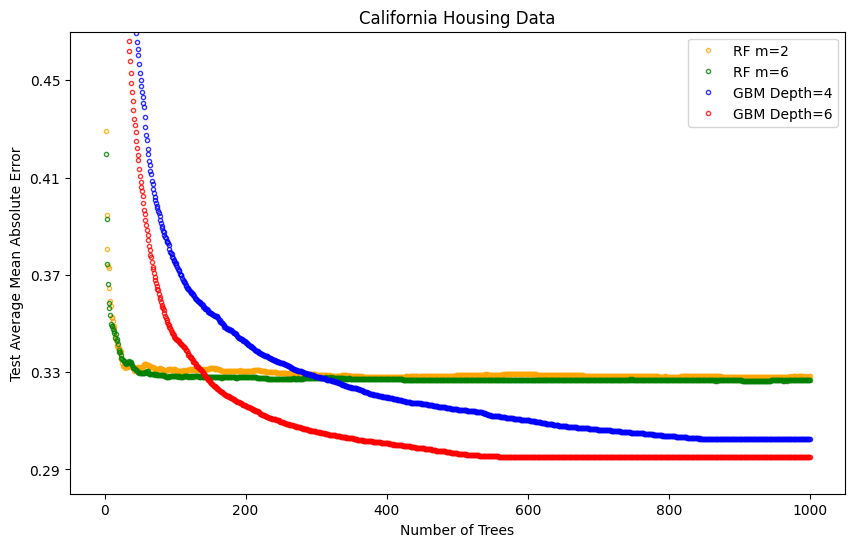

In [73]:
M_values = range(1, 1001,1)
gbm_d_4 = np.load('SEC_1_errors.npy')
gbm_d_6 = np.load('SEC_2_errors.npy')
rf_m_2 = np.load('SEC_3_errors.npy')
rf_m_6 = np.load('SEC_4_errors.npy')
 
plt.figure(figsize=(10, 6))
plt.plot(M_values, rf_m_2, label='RF m=2', color='orange', linestyle='None', marker='o', markersize=3, markerfacecolor='none', markeredgecolor='orange', alpha=0.8)
plt.plot(M_values, rf_m_6, label='RF m=6', color='green', linestyle='None', marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', alpha=0.8)
plt.plot(M_values, gbm_d_4, label='GBM Depth=4', color='blue', linestyle='None', marker='o', markersize=3, markerfacecolor='none', markeredgecolor='blue', alpha=0.8)
plt.plot(M_values, gbm_d_6, label='GBM Depth=6', color='red', linestyle='None', marker='o', markersize=3, markerfacecolor='none', markeredgecolor='red', alpha=0.8)


plt.title('California Housing Data')
plt.xlabel('Number of Trees')
plt.ylabel('Test Average Mean Absolute Error')
plt.legend()
plt.ylim(0.28, 0.47)
plt.xticks([0,200,400,600,800,1000])
plt.yticks([0.29,0.33,0.37,0.41,0.45])
plt.show()